In [3]:
import os
import tensorflow as tf
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import pandas as pd
from keras.utils import generic_utils

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Load Model

In [5]:
#load model
from tensorflow.keras.models import load_model

model_dir ='/media/tohn/SSD/ModelEfficientV2/USAI/ViewingAngle_model/fold1/R1/models/V2m_R1_ViewingAngle_fold1_2.h5'
model = load_model(model_dir)
height = width = model.input_shape[1]

2022-10-05 15:42:44.555201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 15:42:44.965500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9621 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


# DATA

In [6]:
#Train
dataframe = pd.read_csv('/home/yupaporn/codes/USAI/Traindf_fold1_2_viewingAngle.csv')  #Traindf_fold1_2_viewingAngle.csv
dataframe = dataframe[dataframe['Sub_Position_New'] != 'None']
print(dataframe.shape)
dataframe.head()

#validation
#validation
valframe = pd.read_csv('/home/yupaporn/codes/USAI/Testdf_2_viewingAngle.csv') #เปลี่ยนตาม fold
valframe = valframe[valframe['Sub_Position_New'] != 'None']
print(valframe.shape)
valframe.head()

DATA_PATH = "/media/tohn/SSD/Images/Image1"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
validation_dir = os.path.join(DATA_PATH, 'validation')
print(validation_dir)

(6682, 26)
(1214, 25)
/media/tohn/SSD/Images/Image1/train
/media/tohn/SSD/Images/Image1/validation


In [7]:
valframe.head()

,Unnamed: 0,Case,Abs Position,Sub Position,Class,Path Full,Path Crop,Views,fold,15AB,...,Rleft,Rtop,Rwidth,Rheight,Sub_class_New,tag_AjNit,tag_AjWan,Test150,Spilt,Sub_Position_New
0,111,40,P1,P1,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,2,MildFattyLiver,...,0.092664,0.148873,0.513514,0.346614,AB01,NaN,NaN,False,Test,P1
1,112,40,P2,P2,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,2,MildFattyLiver,...,0.171698,0.154849,0.560377,0.428287,AB01,NaN,NaN,False,Test,P2
2,113,40,P4,P41,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-B,2,MildFattyLiver,...,0.140316,0.150865,0.667984,0.711155,AB01,NaN,NaN,False,Test,P4
3,114,40,P5,P51,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-C,2,MildFattyLiver,...,0.063462,0.107041,0.690385,0.653386,AB01,NaN,NaN,False,Test,P6
4,115,40,P3,P31,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-B,2,MildFattyLiver,...,0.216374,0.146881,0.672515,0.625498,AB01,NaN,NaN,False,Test,P3


In [9]:
valframe.columns

Index(['Unnamed: 0', 'Case', 'Abs Position', 'Sub Position', 'Class',
       'Path Full', 'Path Crop', 'Views', 'fold', '15AB', 'originalImage',
       'left', 'top', 'width', 'height', 'Rleft', 'Rtop', 'Rwidth', 'Rheight',
       'Sub_class_New', 'tag_AjNit', 'tag_AjWan', 'Test150', 'Spilt',
       'Sub_Position_New'],
      dtype='object')

In [10]:
#Setting data loader
batch_size = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      brightness_range=[0.5,1.5],
      shear_range=0.4,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(
        dataframe = valframe,
        directory = validation_dir,
        x_col = 'Path Crop',
        y_col = 'Sub_Position_New',
        target_size = (height, width),
        batch_size=batch_size,
        color_mode= 'rgb',
        class_mode='categorical')

#label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 1214 validated image filenames belonging to 12 classes.
{0: 'P1', 1: 'P10', 2: 'P11', 3: 'P13', 4: 'P14', 5: 'P16', 6: 'P2', 7: 'P3', 8: 'P4', 9: 'P5', 10: 'P6', 11: 'P8'}


## Predict Step

In [11]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    return result[0]

#Predict
pred_list = list()
prob_list = list()
img_path=valframe['Path Crop'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    prob_list.append(predict[result])

2022-10-05 15:44:06.460521: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-05 15:44:06.811283: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 38ms/step


In [12]:
valframe['category_FP'] = pred_list
valframe['Prob_FP'] = prob_list
valframe

,Unnamed: 0,Case,Abs Position,Sub Position,Class,Path Full,Path Crop,Views,fold,15AB,...,Rwidth,Rheight,Sub_class_New,tag_AjNit,tag_AjWan,Test150,Spilt,Sub_Position_New,category_FP,Prob_FP
0,111,40,P1,P1,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,2,MildFattyLiver,...,0.513514,0.346614,AB01,NaN,NaN,False,Test,P1,P1,0.384814
1,112,40,P2,P2,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-A,2,MildFattyLiver,...,0.560377,0.428287,AB01,NaN,NaN,False,Test,P2,P1,0.214097
2,113,40,P4,P41,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-B,2,MildFattyLiver,...,0.667984,0.711155,AB01,NaN,NaN,False,Test,P4,P3,0.351356
3,114,40,P5,P51,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-C,2,MildFattyLiver,...,0.690385,0.653386,AB01,NaN,NaN,False,Test,P6,P3,0.303140
4,115,40,P3,P31,Abnormal,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,/media/tohn/HDD/VISION_dataset/USAI/ABnormal01...,FP-B,2,MildFattyLiver,...,0.672515,0.625498,AB01,NaN,NaN,False,Test,P3,P3,0.267098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,6549,350,P3,P31,Normal,/media/tohn/HDD/VISION_dataset/USAI/US images ...,/media/tohn/HDD/VISION_dataset/USAI/US images ...,FP-B,2,Normal,...,NaN,NaN,NaN,Hard,Easy,True,Test,P3,P3,0.385904
1307,6550,350,P3,P32,Normal,/media/tohn/HDD/VISION_dataset/USAI/US images ...,/media/tohn/HDD/VISION_dataset/USAI/US images ...,FP-B,2,Normal,...,NaN,NaN,NaN,NaN,NaN,False,Test,P8,P11,0.305951
1308,6551,350,P4,P42,Normal,/media/tohn/HDD/VISION_dataset/USAI/US images ...,/media/tohn/HDD/VISION_dataset/USAI/US images ...,FP-B,2,Normal,...,NaN,NaN,NaN,Easy,Easy,False,Test,P5,P5,0.385258
1310,6553,350,P6,P61,Normal,/media/tohn/HDD/VISION_dataset/USAI/US images ...,/media/tohn/HDD/VISION_dataset/USAI/US images ...,FP-C,2,Normal,...,NaN,NaN,NaN,Hard,Easy,True,Test,P13,P13,0.192380


In [13]:
data_train = valframe
#เช็คคลาสใน Predicted
pred_class = sorted(set(data_train['category_FP']))
print('Predicted : ',len(pred_class))
print(pred_class)
print('-'*50)
#เช็คคลาสใน Actual
classe = sorted(set(data_train['Sub_Position_New']))
print('Actual : ',len(classe))
print(classe)

Predicted :  11
['P1', 'P10', 'P11', 'P13', 'P16', 'P2', 'P3', 'P4', 'P5', 'P6', 'P8']
--------------------------------------------------
Actual :  12
['P1', 'P10', 'P11', 'P13', 'P14', 'P16', 'P2', 'P3', 'P4', 'P5', 'P6', 'P8']


In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix

act = data_train['Sub_Position_New'].array
pred = data_train['category_FP'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 56.672158154859964%
              precision    recall  f1-score   support

          P1       0.54      0.54      0.54       140
         P10       0.56      0.74      0.64        94
         P11       0.54      0.75      0.63       102
         P13       0.73      0.61      0.66       119
         P14       0.00      0.00      0.00        32
         P16       0.35      0.96      0.52        71
          P2       0.67      0.53      0.59       118
          P3       0.53      0.58      0.55       136
          P4       0.65      0.48      0.55       101
          P5       0.53      0.53      0.53       105
          P6       0.90      0.57      0.70       125
          P8       0.77      0.14      0.24        71

    accuracy                           0.57      1214
   macro avg       0.56      0.53      0.51      1214
weighted avg       0.60      0.57      0.56      1214



/home/kannika/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kannika/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kannika/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 21.249999999999993, 'Predicted label')

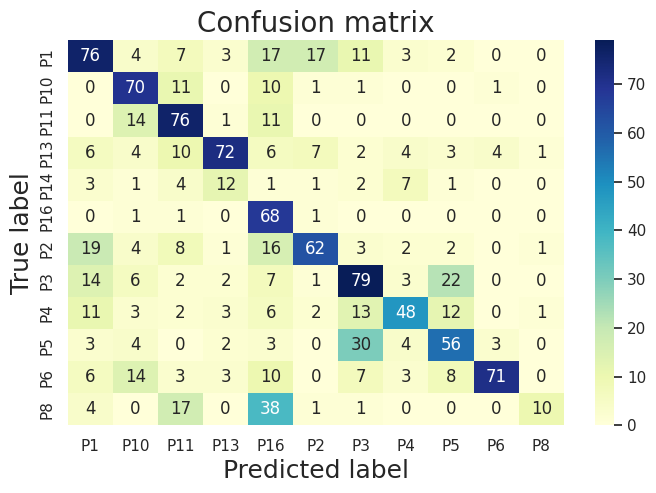

In [15]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)